In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import metrics
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.
e:\envs\python36env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\envs\python36env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\envs\python36env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\envs\python36env\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

In [2]:
data_csv = pd.read_csv('GBPUSD_data_D1.csv')

In [3]:
data_csv.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
print(data_csv)

        close
0     1.58809
1     1.58578
2     1.58089
3     1.57886
4     1.58176
...       ...
2005  1.21020
2006  1.21937
2007  1.22502
2008  1.22363
2009  1.22161

[2010 rows x 1 columns]


In [5]:
data_origin = np.array(data_csv)
# #Max-Min标准化
# #建立MinMaxScaler对象
# scaler = preprocessing.StandardScaler()
# # 标准化处理
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data_origin)

data

array([[0.77503379],
       [0.77097924],
       [0.76239622],
       ...,
       [0.13776701],
       [0.13532726],
       [0.13178172]])

In [6]:
data_y = data[-2000:,:]
print(data_y.shape)

(2000, 1)


In [7]:
data_x = []
for r in range(2000):
    for c in range(10):
        item = []
        item.append(data[r+c, 0])
        data_x.append(item)
data_x = np.array(data_x)
print(data_x)
print(data_x.shape)

[[0.77503379]
 [0.77097924]
 [0.76239622]
 ...
 [0.12785003]
 [0.13776701]
 [0.13532726]]
(20000, 1)


In [8]:
data_x=data_x.reshape(2000,10,1)

In [9]:
data_x.shape

(2000, 10, 1)

In [10]:
data_x_train = data_x[:,:, :]
data_y_train = data_y[:,:]

data_x_test = data_x[-200:,:, :]
data_y_test = data_y[-200:,:]

In [11]:
print(data_x_train.shape)
print(data_y_train.shape)
print(data_x_test.shape)
print(data_y_test.shape)

(2000, 10, 1)
(2000, 1)
(200, 10, 1)
(200, 1)


In [12]:
def create_model(output_dim1, num_layer, output_dim2):
    model = Sequential()

    model.add(LSTM(output_dim=output_dim1, 
                input_shape=(10, 1),
                activation='relu',
                return_sequences=True))
    for i in range(num_layer):
        model.add(LSTM(output_dim=output_dim2,
                        activation='tanh',
                        return_sequences=True))
#     model.add(Dropout(0.1))
    model.add(LSTM(output_dim=output_dim2,
                        activation='tanh'))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
#     model.summary()
    return model

In [13]:
# #采用暴力搜索，所有参数进行组合，然后选择最好的参数
# tuned_parameters=[{'output_dim1':Integer(28, 128),
#                    'num_layer':Integer(3,12),
#                    'output_dim2':Integer(28, 128)}]
# # 'output_dim1':Integer(28, 128),
# #             'num_layer':Integer(3,12),
# #             'output_dim2':Integer(28, 128)

In [14]:
# train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, train_size=0.80, random_state=0)

In [15]:
# #采用随机搜索，给参数一个范围，然后系统随机选择参数，进行检验，然后选择最好的
# tuned_parameters={'output_dim1':[28, 64, 96, 128],
#                    'num_layer':[4,5,6],
#                    'output_dim2':[28, 64, 96, 128]}

# lstm=RandomizedSearchCV(model,tuned_parameters,scoring='neg_mean_squared_error',n_iter=2)
 
# lstm.fit(data_x_train,data_y_train)
# print('best parameters:',lstm.best_estimator_)
# # print(classification_report(test_y,clf.predict(test_x)))
# # print(metrics.confusion_matrix(test_y,clf.predict(test_x)))

In [77]:
model=KerasRegressor(build_fn=create_model)

In [81]:
bayes_cv_tuner = BayesSearchCV(estimator = model,
                               search_spaces = { 'output_dim1':[12,48,64,88,128],
                                                'num_layer':[4,5],
                                                'output_dim2':[12,48,64,88,128]},
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = 2,   
                               verbose = 1,
                               refit = True,
                               random_state = 1885,
                               return_train_score = True)


In [82]:
def status_print(optim_result):
    """bayes参数优化过程中．．．"""

    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest MSE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 5),
        bayes_cv_tuner.best_params_
    ))

    # Save all model results
    lstm_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(lstm_name+"_cv_results.csv")

In [83]:
bayes_cv_tuner.fit(data_x,data_y, callback=status_print)
# bayes_cv_tuner.fit(data_x,data_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 193s 121ms/step - loss: 0.0315 - mean_absolute_error: 0.1181


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 177s 111ms/step - loss: 0.0399 - mean_absolute_error: 0.1277


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 184s 115ms/step - loss: 0.0616 - mean_absolute_error: 0.1730


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 200s 125ms/step - loss: 0.0532 - mean_absolute_error: 0.1581


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 175s 109ms/step - loss: 0.0627 - mean_absolute_error: 0.1757


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.9min finished


Model #1
Best MSE: -0.00619
Best params: OrderedDict([('num_layer', 4), ('output_dim1', 64), ('output_dim2', 88)])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 197s 123ms/step - loss: 0.0286 - mean_absolute_error: 0.1097


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 209s 130ms/step - loss: 0.0604 - mean_absolute_error: 0.1689


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 221s 138ms/step - loss: 0.0554 - mean_absolute_error: 0.1530


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 225s 141ms/step - loss: 0.0666 - mean_absolute_error: 0.1848


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
1600/1600 [==============================] - 237s 148ms/step - loss: 0.0723 - mean_absolute_error: 0.1992


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 25.6min finished
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys


Model #2
Best MSE: -0.00331
Best params: OrderedDict([('num_layer', 5), ('output_dim1', 64), ('output_dim2', 88)])



e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


Epoch 1/1
2000/2000 [==============================] - 274s 137ms/step - loss: 0.0478 - mean_absolute_error: 0.1446


BayesSearchCV(cv=5, error_score='raise',
              estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001B37FCE30F0>,
              fit_params=None, iid=True, n_iter=2, n_jobs=1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=1885,
              refit=True, return_train_score=True,
              scoring='neg_mean_squared_error',
              search_spaces={'num_layer': [4, 5],
                             'output_dim1': [12, 48, 64, 88, 128],
                             'output_dim2': [12, 48, 64, 88, 128]},
              verbose=1)

In [84]:
bayes_cv_tuner.best_params_

OrderedDict([('num_layer', 5), ('output_dim1', 64), ('output_dim2', 88)])

In [13]:
model = create_model(64, 5, 88)

Instructions for updating:
Colocations handled automatically by placer.


e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), activation="relu", return_sequences=True, units=64)`
  import sys
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=88)`
  # This is added back by InteractiveShellApp.init_path()
e:\envs\python36env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", units=88)`
  


In [14]:
model.fit(data_x_train, data_y_train, epochs=50, batch_size=500, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2000/2000 [==============================] - 13s 6ms/step - loss: 0.2794 - mean_absolute_error: 0.4591
Epoch 2/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1420 - mean_absolute_error: 0.2963
Epoch 3/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0854 - mean_absolute_error: 0.2464
Epoch 4/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0613 - mean_absolute_error: 0.2175
Epoch 5/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0689 - mean_absolute_error: 0.2215
Epoch 6/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0494 - mean_absolute_error: 0.2004
Epoch 7/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0453 - mean_absolute_error: 0.1788
Epoch 8/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0253 - mean_absolute_error: 0.1422
Epoch 9/50
2000/2000 [=========================

In [15]:
# 评估模型,不输出预测结果
loss,mae= model.evaluate(data_x_test,data_y_test)
print('\ntest loss','{:.5f}'.format(loss))
print('mae','{:.5f}'.format(mae))

200/200 [==============================] - 2s 8ms/step

test loss 0.00226
mae 0.02893


In [16]:
y_pred = model.predict(data_x_test,batch_size = 1)

In [ ]:
# y_pred[-10:]

In [ ]:
# data_y_test[-10:,0]

In [ ]:
# data_x_test[-10:,0,-1]

In [ ]:
# t = []
# for i in range(1000):
#     if data_y_test[:,0][i]>data_x_test[:,0,-1][i]:
#         t.append(1)
#     else:
#         t.append(0)
# len(t)

In [ ]:
# p = []
# for i in range(1000):
#     if y_pred[:,0][i]>data_x_test[:,0,-1][i]:
#         p.append(1)
#     else:
#         p.append(0)
# len(p)

In [ ]:
# n = 0
# for i in range(1000):
#     if t[i]==p[i]:
#         n=n+1
# n/1000

In [ ]:
# model.save('model.h5')#保存名为model的h5文件到程序所在目录

In [ ]:
# data_x_test.shape

In [ ]:
# model.predict(data_x_test,batch_size = 1)

In [ ]:
# x_pred = [1.08244, 1.0776, 1.08229, 1.08564, 1.08607, 1.08739, 1.08386, 1.09066, 1.09798, 1.0912]
# 

In [ ]:
# x_pred = np.array(x_pred).reshape(1,10,1)

In [ ]:
# x_pred.shape

In [ ]:
# model.predict(x_pred,batch_size = 1).tolist()[0][0]

In [ ]:
# y_pred.shape

In [ ]:
# y_pred

In [17]:
y_t = data_y_test.reshape(200)

In [18]:
y_p = y_pred.reshape(200)

In [19]:
 df_test_output = pd.DataFrame(columns=['真实值', '预测值'])

In [20]:
df_test_output['真实值'] = y_t

In [21]:
df_test_output['预测值'] = y_p

In [22]:
df_test_output

,真实值,预测值
0,0.103365,0.146602
1,0.108086,0.145982
2,0.119004,0.146143
3,0.115686,0.145132
4,0.123322,0.144226
...,...,...
195,0.111755,0.179564
196,0.127850,0.175217
197,0.137767,0.171877
198,0.135327,0.167790


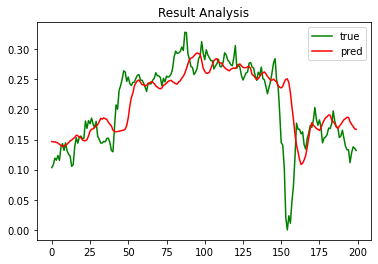

In [23]:
x_axix = range(200)
#x_axix，train_pn_dis这些都是长度相同的list()

#开始画图
plt.title('Result Analysis')
plt.plot(x_axix, y_t, color='green', label='true')
plt.plot(x_axix, y_p, color='red', label='pred')
plt.legend() # 显示图例

# plt.xlabel('iteration times')
# plt.ylabel('rate')
plt.show()

In [24]:
df_test_output.to_csv('GBPUSD_test_output.csv',encoding='utf_8_sig')

In [25]:
y_t.tolist()

[0.10336475172450177,
 0.1080862864865817,
 0.11900373861302738,
 0.1156863777578856,
 0.12332157337686311,
 0.11542309515033455,
 0.13760904287996079,
 0.14312042546469428,
 0.13195724290453414,
 0.14443683850244904,
 0.13137802116792185,
 0.12542783423727055,
 0.12237375598967981,
 0.10555877345409304,
 0.10833201692029615,
 0.13808295157355266,
 0.15286188194407924,
 0.14387516893967334,
 0.154178294981834,
 0.15565267758411938,
 0.15138749934179385,
 0.15228266020746695,
 0.18061186877994828,
 0.1684833166587687,
 0.1812612992119078,
 0.1762062731469296,
 0.1855089252803963,
 0.17582012532252156,
 0.16920295578607414,
 0.18024327312937727,
 0.1553367384550577,
 0.1501237428255493,
 0.1442437645902448,
 0.14413845154722438,
 0.14694679936110155,
 0.14620960805995864,
 0.1517560949923653,
 0.15217734716444653,
 0.14466501676232646,
 0.13178172116616693,
 0.12964035595808543,
 0.1701332209994213,
 0.20737893388096174,
 0.20028785565092289,
 0.23146051638495457,
 0.23937654678531972,
 

In [26]:
y_p.tolist()

[0.14660194516181946,
 0.14598198235034943,
 0.14614324271678925,
 0.14513181149959564,
 0.1442260444164276,
 0.14203080534934998,
 0.1401408463716507,
 0.13814932107925415,
 0.13996143639087677,
 0.14058592915534973,
 0.14226268231868744,
 0.14496171474456787,
 0.147669717669487,
 0.1489696204662323,
 0.15154336392879486,
 0.15323470532894135,
 0.15709325671195984,
 0.15638482570648193,
 0.15376104414463043,
 0.15318982303142548,
 0.1494031399488449,
 0.1480252593755722,
 0.14814046025276184,
 0.14958345890045166,
 0.15590250492095947,
 0.1638767421245575,
 0.1669376790523529,
 0.16743484139442444,
 0.17067638039588928,
 0.17244142293930054,
 0.1748117059469223,
 0.1793985217809677,
 0.185085266828537,
 0.18392875790596008,
 0.185940682888031,
 0.1843011975288391,
 0.18322455883026123,
 0.1786290854215622,
 0.17519444227218628,
 0.1723601222038269,
 0.16536210477352142,
 0.16357024013996124,
 0.16275055706501007,
 0.16325148940086365,
 0.16393506526947021,
 0.16425317525863647,
 0.165

In [27]:
data_max = np.max(data_origin)
data_min = np.min(data_origin)
print(data_max)
print(data_min)

1.71626
1.1465299999999998


In [28]:
y_pred_to_origin = []
for i in y_p:
    y = i*(data_max - data_min) + data_min
    y_pred_to_origin.append(y)

In [29]:
len(y_pred_to_origin)

200

In [30]:
y_test_to_origin=data_origin[-200:,:]

In [31]:
len(y_test_to_origin)

200

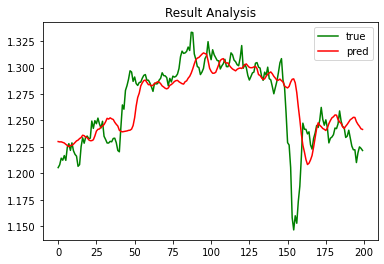

In [32]:
x_axix = range(200)
#x_axix，train_pn_dis这些都是长度相同的list()

#开始画图
plt.title('Result Analysis')
plt.plot(x_axix, y_test_to_origin, color='green', label='true')
plt.plot(x_axix, y_pred_to_origin, color='red', label='pred')
plt.legend() # 显示图例

# plt.xlabel('iteration times')
# plt.ylabel('rate')
plt.show()

In [33]:
model.save('GBPUSD_pre_model.h5')#保存名为model的h5文件到程序所在目录